In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import statsmodels
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import mean_squared_error
import sklearn.metrics 
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
%matplotlib inline
from pmdarima.arima import auto_arima

In [81]:
# Carregando os dados:
df=pd.read_csv('Sunspots.csv')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
df = df[['Monthly Mean Total Sunspot Number']].groupby('Date').sum()
df.rename(columns={'Monthly Mean Total Sunspot Number': 'sunspots'}, inplace = True)
# reduzindo amostra:
#df_sunspots = df[2065:3265]
df_sunspots=df.dropna()
df_sunspots.head(2)

,sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3


In [30]:
df_sunspots.iloc[[0, -1]]

,sunspots
Date,
1749-01-31,96.7
2021-01-31,10.4


In [31]:
# conhecendo os dados:
df_sunspots.head(10)

,sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
1749-06-30,139.2
1749-07-31,158.0
1749-08-31,110.5
1749-09-30,126.5


In [32]:
# conhecendo os dados:
df_sunspots.tail(10)

,sunspots
Date,
2020-04-30,5.2
2020-05-31,0.2
2020-06-30,5.8
2020-07-31,6.1
2020-08-31,7.5
2020-09-30,0.6
2020-10-31,14.4
2020-11-30,34.0
2020-12-31,21.8


In [6]:
# conhecendo os dados:
df_sunspots.info()
df_sunspots.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1200 entries, 1921-02-28 to 2021-01-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sunspots  1200 non-null   float64
dtypes: float64(1)
memory usage: 18.8 KB


,sunspots
count,1200.000000
mean,90.046583
std,73.564166
min,0.000000
25%,26.875000
50%,72.700000
75%,140.050000
max,359.400000


In [7]:
df.isna().values.any()

False

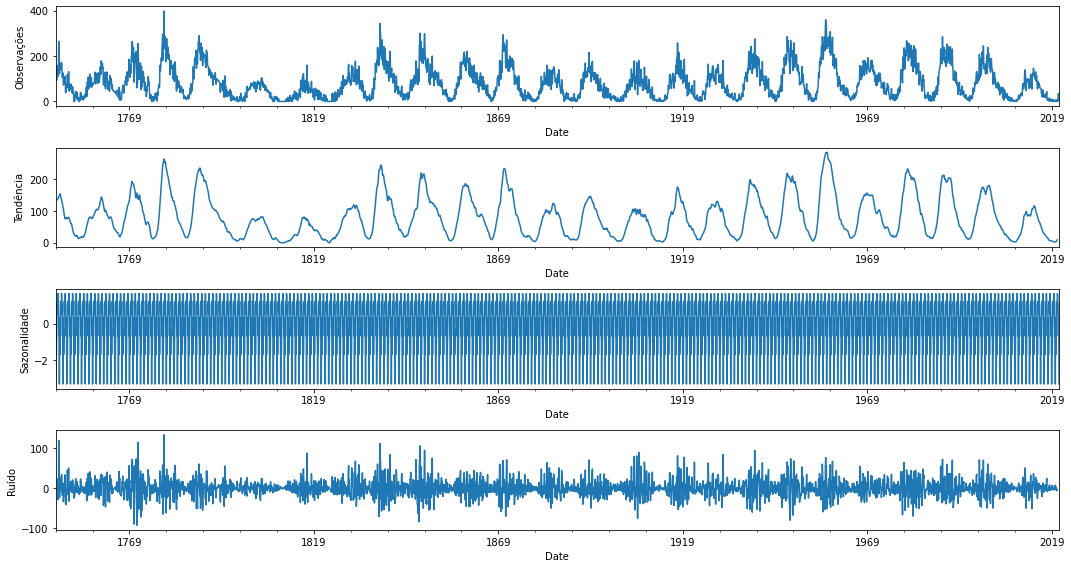

In [41]:
# decompondo a série:
seasonplot = seasonal_decompose(df_sunspots)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1, ylabel='Observações') 
seasonplot.trend.plot(ax=ax2, ylabel='Tendência') 
seasonplot.seasonal.plot(ax=ax3, ylabel='Sazonalidade')
seasonplot.resid.plot(ax=ax4, ylabel='Ruído') 
plt.tight_layout()


In [42]:
# aplicando o teste Dickey-Fuller Aumentado (ADF) para verificar estacionariedade na série:

# Extraindo a coluna que contém os dados da série temporal
dados_serie = df_sunspots['sunspots']
resultado_adf = adfuller(dados_serie)

# Extraindo os resultados do teste ADF
valor_p = resultado_adf[1]
estatistica_teste = resultado_adf[0]

# Comparando o valor-p com um nível de significância (geralmente 0.05)
nivel_de_significancia = 0.05

if valor_p <= nivel_de_significancia:
    print("A série temporal é estacionária (rejeita-se a hipótese nula).")
else:
    print("A série temporal não é estacionária (não se rejeita a hipótese nula).")

# Exiba a estatística do teste
print(f"Estatística do teste ADF: {estatistica_teste}")
print(f"Valor-p: {valor_p}")

A série temporal é estacionária (rejeita-se a hipótese nula).
Estatística do teste ADF: -10.497051662546141
Valor-p: 1.10855249219565e-18


In [43]:
# em caso negativo, para teste do melhor resultado da série para se tornar estacionária, pode ser aplicado a diferenciação:
#diff_1 = dados_serie.diff().dropna()
# testar novamente por ADF

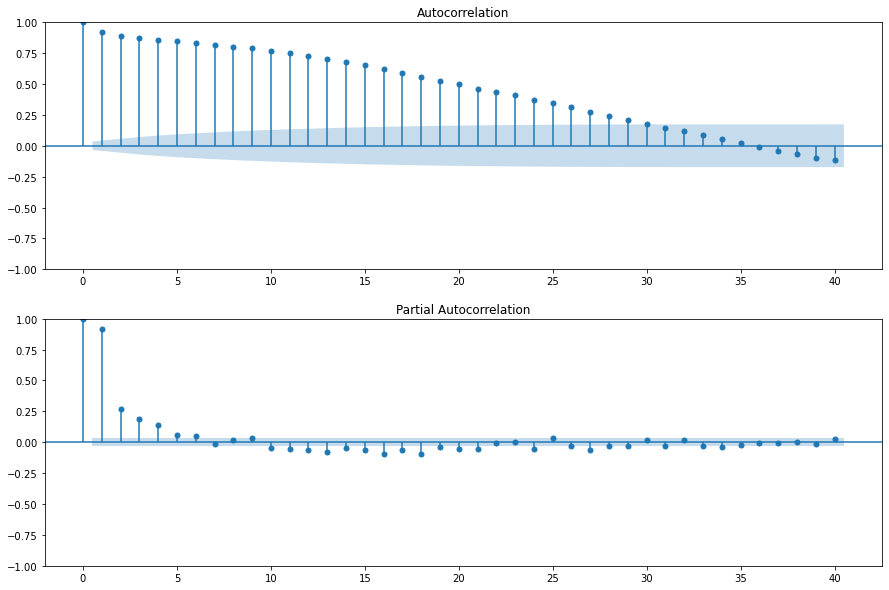

In [44]:
# verificando autocorrelação e autocorrelação parcial:
# auto-regressão (p) = autorrelação; média móvel (q)= autocorrelação parcial.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
sm.graphics.tsa.plot_acf(df_sunspots.values.squeeze(), lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(df_sunspots.values.squeeze(), lags= 40, ax=ax2, method='ywm')
plt.show()

In [45]:
# Aplicando método Auto ARIMA (já pode-se definir max e min valores dos parâmetros para facilitar o código):
# A sazonalidade, se mensal, usar m=12; Por padrão o P iniciará em 0 e o máximo será 2; o Q por padrão será 1 e o máximo, por padrão, será 2; o d será 1 e o máximo, por padrão, será 2; o D será 1, por padrão já é 1.
# Serão gerados vários modelos ARIMA e os seus respectivos AIC's e BICS (critérios de informação).
# Stepwise permite diminuir o número de modelos gerados, deixa o código mais leve.
stepwise=auto_arima(df_sunspots,start_p=0, start_q=0,max_p=3,max_q=2,m=4,start_P=0,
                     seasonal=True,d=0,D=1,trace=True, error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[4] intercept   : AIC=32366.574, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=32626.268, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=31342.795, Time=0.71 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=31542.222, Time=0.77 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=32624.294, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=31954.784, Time=0.19 sec
 ARIMA(1,0,0)(2,1,0)[4] intercept   : AIC=31114.762, Time=2.35 sec
 ARIMA(1,0,0)(2,1,1)[4] intercept   : AIC=inf, Time=10.99 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=4.43 sec
 ARIMA(0,0,0)(2,1,0)[4] intercept   : AIC=32338.164, Time=2.23 sec
 ARIMA(2,0,0)(2,1,0)[4] intercept   : AIC=31057.478, Time=4.94 sec
 ARIMA(2,0,0)(1,1,0)[4] intercept   : AIC=31320.590, Time=2.85 sec
 ARIMA(2,0,0)(2,1,1)[4] intercept   : AIC=inf, Time=7.21 sec
 ARIMA(2,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=8.95 sec
 ARIMA(3,0,0)(2,1,0)[4] intercept   : AIC=

In [46]:
# verificando resultado e menor AIC:
stepwise

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(2, 1, 0, 4),
      suppress_warnings=True, with_intercept=False)

In [47]:
stepwise.aic()

30949.987892857134

In [49]:
# testando mais um modelo, com parâmetro diferente, por exemplo de sazonalidade D:
stepwise1=auto_arima(df_sunspots,start_p=0, start_q=0,max_p=3,max_q=2,m=2,start_P=0,
                     seasonal=True,d=0,D=0,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[2] intercept   : AIC=34587.789, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=36811.412, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=30755.778, Time=1.26 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=32406.000, Time=0.96 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=39737.115, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[2] intercept   : AIC=30766.403, Time=0.28 sec
 ARIMA(1,0,0)(2,0,0)[2] intercept   : AIC=30870.303, Time=1.83 sec
 ARIMA(1,0,0)(1,0,1)[2] intercept   : AIC=30636.520, Time=1.51 sec
 ARIMA(1,0,0)(0,0,1)[2] intercept   : AIC=30757.193, Time=0.80 sec
 ARIMA(1,0,0)(2,0,1)[2] intercept   : AIC=30587.400, Time=4.67 sec
 ARIMA(1,0,0)(2,0,2)[2] intercept   : AIC=30456.459, Time=6.28 sec
 ARIMA(1,0,0)(1,0,2)[2] intercept   : AIC=30578.474, Time=3.77 sec
 ARIMA(0,0,0)(2,0,2)[2] intercept   : AIC=inf, Time=5.12 sec
 ARIMA(1,0,1)(2,0,2)[2] intercept   : AIC=30297.261, Time=5.85 sec
 ARIMA(1,0,1)(1,0,2)[2] i

In [50]:
# verificando demais resultados com menores AIC:
stepwise1
stepwise1.aic()

30297.261122570235

In [82]:
# validar modelo
# separando os dados de treino e teste: os dados de treino (70% inicial da amostra) serão usado para treinar o modelo ARIMA e os dados de teste(30% restante) para comparar com as previsões geradas.
# amostra=100anos, treino=70anos, teste=30 anos...
train=df_sunspots.loc['1749-01-31':'2010-01-31']
test=df_sunspots.loc['2019-01-31':'2021-01-31']

In [83]:
stepwise.fit(train)
stepwise1.fit(train)

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(2, 0, 2, 2),
      suppress_warnings=True)

In [84]:
# calculando previsões para n periodos futuros:
future_forecast=stepwise.predict(n_periods=360)
future_forecast1=stepwise1.predict(n_periods=360)

In [85]:
future_forecast=pd.DataFrame(future_forecast,index=test.index, columns=['previsão modelo 1'])
future_forecast1=pd.DataFrame(future_forecast1,index=test.index, columns=['previsão modelo 2'])

In [86]:
future_forecast.head(10)
future_forecast1.head(10)

,previsão modelo 2
Date,
2019-01-31,80.959461
2019-02-28,81.046460
2019-03-31,81.130974
2019-04-30,81.213075
2019-05-31,81.292831
2019-06-30,81.370310
2019-07-31,81.445575
2019-08-31,81.518692
2019-09-30,81.589720


<Figure size 1440x360 with 0 Axes>

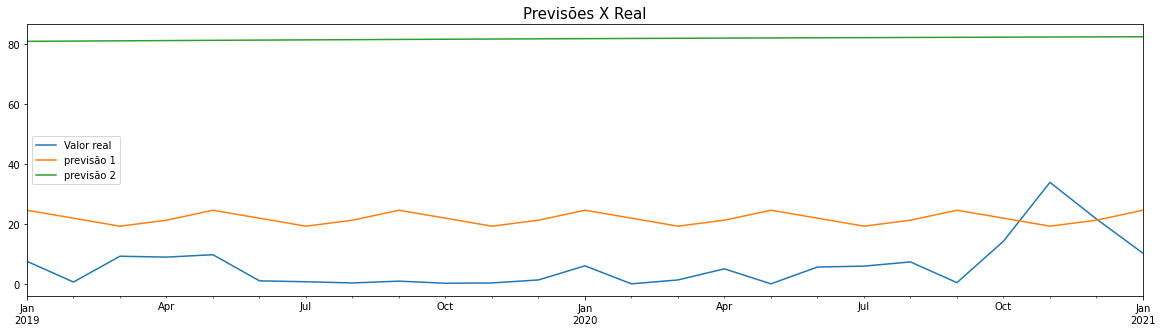

In [87]:
plt.figure(figsize=(20,5))
pd.concat([test,future_forecast,future_forecast1],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.legend(['Valor real','previsão 1','previsão 2'])
plt.show();

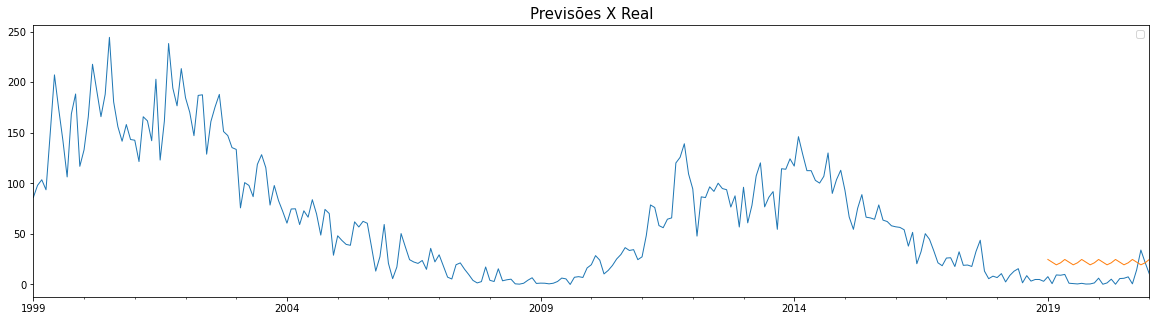

In [89]:
pd.concat([df_sunspots['1999-01-31':],future_forecast],axis=1).plot(linewidth=1,figsize=(20,5))
plt.legend('')
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.show();

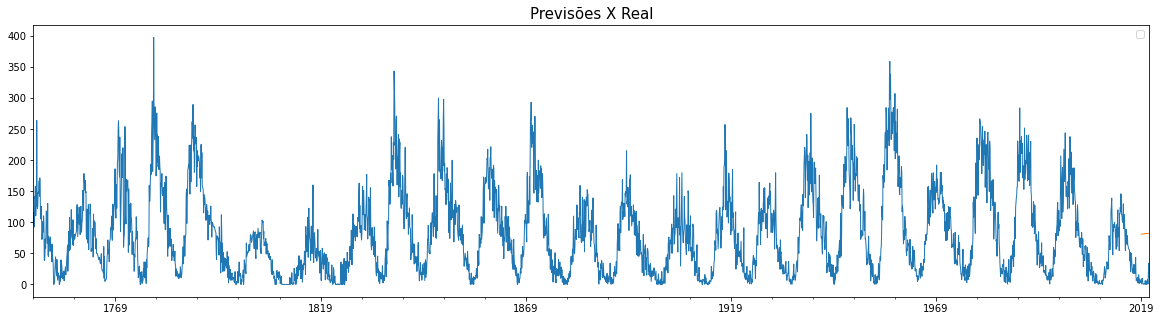

In [90]:
pd.concat([df_sunspots,future_forecast1],axis=1).plot(linewidth=1, figsize=(20,5))
plt.legend('')
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.show();

In [91]:
stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3133
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 4)   Log Likelihood              -14882.549
Date:                            Fri, 03 Nov 2023   AIC                          29777.098
Time:                                    22:42:05   BIC                          29813.388
Sample:                                01-31-1749   HQIC                         29790.123
                                     - 01-31-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2801      0.031     41.932      0.000       1.220       1.340
ar.L2         -0.3193      0.025    -12.604      0.000      -0.369      -0.270
ma.L1         -0.7858      0.024    -32.533      0.000      -0.833      -0.738
ar.S.L4       -0.6266      0.014    -43.801      0.000      -0.655      -0.599
ar.S.L8       -0.3315      0.013    -24.714      0.000      -0.358      -0.305
sigma2       791.6833     13.245     59.773      0.000     765.724     817.643
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               922.77
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.26
Prob(H) (two-sided):                  0.48   Kurtosis:                         5.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
stepwise1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 3133
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 2)   Log Likelihood              -14568.479
Date:                                Fri, 03 Nov 2023   AIC                          29152.958
Time:                                        22:42:06   BIC                          29201.356
Sample:                                    01-31-1749   HQIC                         29170.328
                                         - 01-31-2010                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3383      0.106      3.188      0.001       0.130       0.546
ar.L1          0.9714      0.006    161.061      0.000       0.960       0.983
ma.L1         -0.4416      0.014    -30.828      0.000      -0.470      -0.414
ar.S.L2        1.2862      0.081     15.977      0.000       1.128       1.444
ar.S.L4       -0.4272      0.084     -5.062      0.000      -0.593      -0.262
ma.S.L2       -1.3937      0.074    -18.845      0.000      -1.539      -1.249
ma.S.L4        0.5599      0.078      7.213      0.000       0.408       0.712
sigma2       639.2811     10.373     61.631      0.000     618.951     659.611
===================================================================================
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):              1630.87
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.64
Prob(H) (two-sided):                  0.35   Kurtosis:                         6.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
# função para calcular o erro dos modelos
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

def check_erro(orig, prev, nome_col='', nome_indice=''):
    
    vies = np.mean(orig - prev)
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = np.mean(np.abs((orig - prev) / orig)) * 100
    
    grupo_erro = [vies, mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['VIÉS','MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice
    
    return serie

In [94]:
# Análise dos erros/resíduos, ideal é o mais próximo de zero
check_erro(test,future_forecast)

,
,
VIÉS,NaN
MSE,316.226214
RMSE,17.782750
MAE,16.932673
MAPE,NaN


In [95]:
check_erro(test,future_forecast1)

,
,
VIÉS,NaN
MSE,5762.180406
RMSE,75.909027
MAE,75.530844
MAPE,NaN


In [96]:
erros=pd.DataFrame(np.array(future_forecast.values.tolist())-np.array(test.values.tolist()))

erros1=pd.DataFrame(np.array(future_forecast1.values.tolist())-np.array(test.values.tolist()))

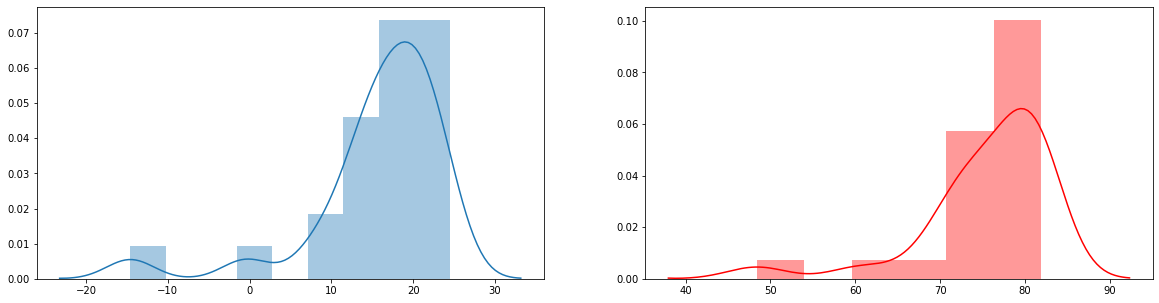

In [97]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(erros,ax=ax[0])
sns.distplot(erros1,ax=ax[1], color='red');

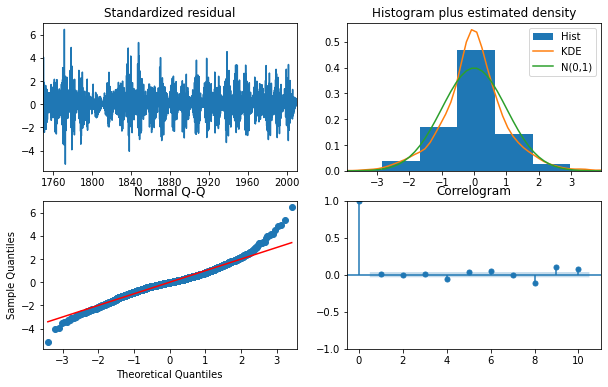

In [98]:
stepwise.plot_diagnostics(figsize=(10,6));

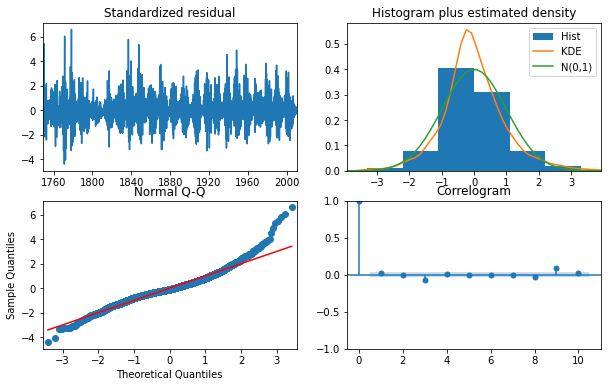

In [99]:
stepwise1.plot_diagnostics(figsize=(10,6));

In [100]:
# Verificado normalidade dos resíduos pelo teste Jarque Bera:
test = jarque_bera(erros)
print('Estatística Jarque-Bera :', test[0])
print('p-valor :', test[1])
print('Assimetria :', test[2])
print('Curtose :',test[3])

Estatística Jarque-Bera : [44.20386095]
p-valor : [2.51914726e-10]
Assimetria : [-2.11187303]
Curtose : [7.95940276]


In [101]:
test1 = jarque_bera(erros1)
print('Estatística Jarque-Bera :', test1[0])
print('p-valor :', test1[1])
print('Assimetria :', test1[2])
print('Curtose :',test1[3])

Estatística Jarque-Bera : [37.26751191]
p-valor : [8.08095357e-09]
Assimetria : [-2.02902647]
Curtose : [7.39420274]


In [102]:
# Aplicando o modelo mais adequado:

stepwise.fit(df)

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(2, 1, 0, 4),
      suppress_warnings=True, with_intercept=False)

In [115]:
future_forecast2=stepwise.predict(n_periods=12)

In [116]:
future_forecast2=pd.DataFrame(future_forecast2, 
                              index=pd.date_range(start='2021-01-31',
                                                  end='2023-01-31'),columns=['Nova previsão'])


In [117]:
future_forecast2.head(24)

,Nova previsão
2021-01-31,NaN
2021-02-01,NaN
2021-02-02,NaN
2021-02-03,NaN
2021-02-04,NaN
2021-02-05,NaN
2021-02-06,NaN
2021-02-07,NaN
2021-02-08,NaN
2021-02-09,NaN


<Figure size 1440x360 with 0 Axes>

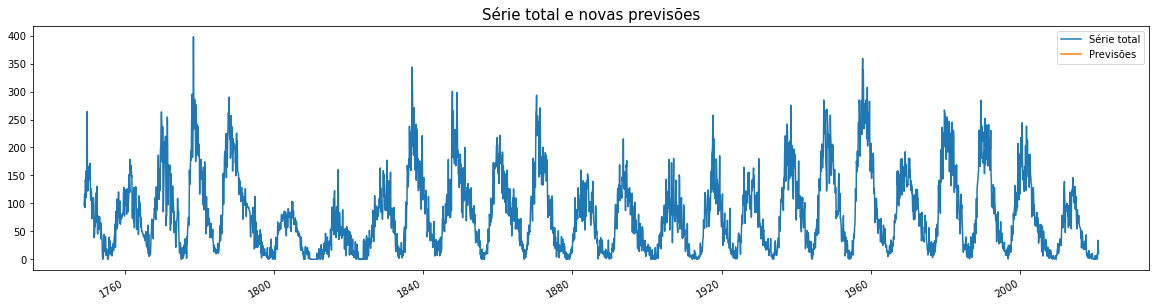

In [106]:
plt.figure(figsize=(20,5))
pd.concat([df,future_forecast2],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Série total e novas previsões',size=15)
plt.legend(['Série total','Previsões'])
plt.show();